# Intro

PCA analysis on the meta-session to see value (history) representation.

---
# Setup

In [1]:
#%% imports
import os

from sklearn.decomposition import PCA
import pandas as pdr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

import popy.config as cfg
import popy.config as cfg

#from popy.dim_reduction import *
from popy.plotting.plotting_tools import plot_keypoints
from popy.plotting.plot_cortical_grid import plot_on_cortical_grid


PATH = cfg.PROJECT_PATH_LOCAL

In [2]:
##% plotting functions
def plot_single_unit(unit_data, labels, labels_2=None, colors=None, linestyles=None, n_extra_trials=(-1, 0), title=None, ax=None):
    time_vector = unit_data.time.data

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # get mean counts by conditions
    for i, label in enumerate(np.unique(labels)):
        if labels_2 is not None:
            for j, label_2 in enumerate(np.unique(labels_2)):
                    trial_ids = unit_data.trial_id[(labels == label) & (labels_2 == label_2)]
                    mean_count = np.mean(unit_data.sel(trial_id=trial_ids), axis=0)
                    ax.plot(time_vector, mean_count, label=f'V_t={label}, R_t={label_2}', color=colors[i], linestyle=linestyles[j])
        else:
            trial_ids = unit_data.trial_id[labels == label]
            mean_count = np.mean(unit_data.sel(trial_id=trial_ids), axis=0)
            ax.plot(time_vector, mean_count, label=f'V_t={label}', color=colors[i])
            
    plot_keypoints(ax, n_extra_trials=n_extra_trials, xlabels='events')

    ax.legend(loc='upper right', fontsize=8)

    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')
    # grid on x axis only
    ax.grid(alpha=.3, axis='x')

    # Add a box at the top left corner
    x_loc = time_vector[0]
    y_loc = ax.get_ylim()[1] 
    y_loc_text = y_loc - (ax.get_ylim()[1] - ax.get_ylim()[0]) * .18
    y_loc_line = y_loc - (ax.get_ylim()[1] - ax.get_ylim()[0]) * .2
    ax.text(x_loc+.5, y_loc_text, '1s', verticalalignment='bottom', horizontalalignment='center')

    # Plot a unit length horizontal line inside the box
    ax.plot([x_loc, x_loc + 1], [y_loc_line, y_loc_line], color='black')
    ax.scatter([x_loc, x_loc + 1], [y_loc_line, y_loc_line], marker='|', color='black')

    # remove top and right spines
    sns.despine()

    if title is not None:
        ax.set_title(title)

def plot_2pcs(unit_data, labels, pc_a, pc_b, condition=None, title=None, ax=None, colors=None):
    time_vector = unit_data.time.data

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # get mean counts by condition
    mean_counts = {label: np.mean(unit_data[labels == label], axis=0) for label in np.unique(labels)}

    # plot trial-avg rates by condition
    for i, label in enumerate(np.unique(labels)):        
        ax.scatter(mean_counts[label][pc_a], mean_counts[label][pc_b], label=f'{int(pc_a)}, N={np.sum(labels == pc_a)}', color=colors[0])

    ax.set_xlabel(f'{pc_a}')
    ax.set_ylabel(f'{pc_b}')
    # grid on x axis only
    ax.grid(alpha=.3, axis='x')
    if condition is not None:
        # legend outside of plot
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
    #ax.axhline(0, color='k', alpha=.5) # add zero line

    # remove top and right spines
    sns.despine()

    if title is not None:
        ax.set_title(title)

def plot_2pcs_in_time():
    pass

def plot_explained_variance(pca_dataset, monkey, area):
    '''
    Simply plots the explained variance of the PCA components
    '''
    # plot cummulative explained variance
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(np.cumsum(pca_dataset.explained_var), color='k')
    ax.set_xlabel('PCA component')
    ax.set_ylabel('Cumulative explained variance')
    ax.set_title(f'Cumulative explained variance\n{monkey}, {area}')
    ax.grid(alpha=.3, axis='x')
    sns.despine()
    plt.tight_layout()

    plt.show()


In [3]:
#%% data tools
def add_subregion_temp(neural_dataset):
        from popy.io_tools import load_metadata
        metadata = load_metadata()

        subregions = []
        for unit in neural_dataset.unit.values:
            monkey_temp = neural_dataset.sel(unit=unit).monkey.values
            session_temp = neural_dataset.sel(unit=unit).session.values
            area_temp = neural_dataset.sel(unit=unit).area.values

            if area_temp == "MCC":
                subregion_temp = 'MCC'
            else:
                subregion_temp = metadata.loc[(metadata['monkey'] == monkey_temp) & (metadata['session'] == session_temp), 'LPFC_subregion'].values[0]

            subregions.append(subregion_temp)
        neural_dataset = neural_dataset.assign_coords(subregion=('unit', subregions))
        return neural_dataset

def load_data_custom(monkey, area=None, subregion=None):
    # load data (meta session)
    floc = os.path.join(PATH, 'data', 'processed', 'neural_data', 'meta_rates_20')
    neural_dataset =  xr.open_dataset(floc + '/meta_rates.nc')

    if area is not None:
        neural_dataset = neural_dataset.sel(unit=neural_dataset.area == area)
    if subregion is not None:
        neural_dataset = neural_dataset.sel(unit=neural_dataset.subregion == subregion)

    neural_dataset = neural_dataset.sel(unit=neural_dataset.monkey == monkey)

    # add coordinates (should be added during the dataset creation)
    neural_dataset = neural_dataset.assign_coords(R_1=('trial_id', [0 if hist in [0, 1, 2, 3] else 1 for hist in neural_dataset.history_of_feedback.values]))
    neural_dataset = neural_dataset.assign_coords(R_2=('trial_id', [0 if hist in [0, 1, 4, 5] else 1 for hist in neural_dataset.history_of_feedback.values]))
    neural_dataset = neural_dataset.assign_coords(R_3=('trial_id', [0 if hist in [0, 2, 4, 6] else 1 for hist in neural_dataset.history_of_feedback.values]))
    neural_dataset = neural_dataset.assign_coords(fb_sequence=('trial_id', neural_dataset.history_of_feedback.values))
    neural_dataset = neural_dataset.assign_coords(fb_sequence_m1=('trial_id', neural_dataset.history_of_feedback.values%4))
    neural_dataset = neural_dataset.assign_coords(time_m1=('time', neural_dataset.time.values + 7.5))

    # normalize firing rates (z-score)
    neural_data = neural_dataset.firing_rates.values  # Get the firing rates data
    normalized_data = np.zeros_like(neural_data)  # Create a copy to avoid modifying the original data
    for i in range(neural_data.shape[1]):  # Loop through each neuron
        # Get all data for this neuron across trials and timepoints
        neuron_data = neural_data[:, i, :]
        
        # Calculate mean and std across all values for this neuron
        mean_val = np.mean(neuron_data)
        std_val = np.std(neuron_data)
        
        # Z-score normalize and store in the output array
        z_scored_data = (neuron_data - mean_val) / std_val
        normalized_data[:, i, :] = z_scored_data
    neural_dataset.firing_rates.values = normalized_data

    return neural_dataset

def fit_transform_data(neural_dataset):
    n_trials, n_neurons, n_time = neural_dataset.firing_rates.data.shape
        
    # Step 1: Reshape to (neurons, trials*time)
    reshaped_data = neural_dataset.firing_rates.data.transpose(1, 0, 2).reshape(n_neurons, -1)

    # smooth the data
    '''unit_smooth = [np.convolve(unit, np.ones(50)/50, mode='same') for unit in reshaped_data]
    reshaped_data = np.array(unit_smooth)

    corr_matrix = np.corrcoef(reshaped_data)
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-.1, vmax=.1)
    plt.title('Correlation Matrix of Smoothed Firing Rates')
    plt.xlabel('Units')
    plt.ylabel('Units')
    plt.show()'''

    # Step 2: Apply PCA (scikit-learn expects samples as rows, features as columns)
    pca = PCA()
    pca = pca.fit(reshaped_data.T)  # Shape: (trials*time, components)
    transformed_data = pca.transform(reshaped_data.T)  # Apply PCA transformation

    # Step 3: Reshape back to (trials, components, time)
    transformed_data = transformed_data.T  # Shape: (components, trials*time)
    transformed_data = transformed_data.reshape(n_neurons, n_trials, n_time)
    transformed_data = transformed_data.transpose(1, 0, 2)  # Final shape: (trials, components, time)

    # rewrite the dataset
    pca_dataset = neural_dataset.copy(deep=True)
    pca_dataset = pca_dataset.rename({'unit': 'pca_component'})
    pca_dataset = pca_dataset.drop('channel')
    pca_dataset = pca_dataset.drop('area')
    pca_dataset = pca_dataset.drop('unit_id_original')
    pca_dataset = pca_dataset.drop('monkey')
    pca_dataset = pca_dataset.drop('session')
    # add pca_component dimension
    pca_dataset = pca_dataset.assign_coords(pca_component=('pca_component', np.arange(n_neurons)))
    pca_dataset = pca_dataset.assign_coords(explained_var=('pca_component', pca.explained_variance_ratio_))
    pca_dataset.firing_rates.data = transformed_data

    # create xr dataset for the pca components (components, units)
    pca_components = xr.DataArray(pca.components_, dims=['pca_component', 'unit'], coords=[np.arange(n_neurons), neural_dataset.unit.values])

    return pca_dataset, pca_components



---
# Get data

In [4]:
monkey = 'po'
area = None#'MCC'
subregion = 'vLPFC'  # 'MCC'
area_title = area if area is not None else subregion

neural_dataset = load_data_custom(monkey, area=area, subregion=subregion)
neural_dataset

<xarray.Dataset>
Dimensions:              (unit: 370, time: 1500, trial_id: 160)
Coordinates: (12/17)
    unit_id_original     (unit) int64 ...
    channel              (unit) int64 ...
    monkey               (unit) object po po po po po po ... po po po po po po
    session              (unit) object ...
    area                 (unit) object ...
    subregion            (unit) object 'vLPFC' 'vLPFC' ... 'vLPFC' 'vLPFC'
    ...                   ...
    R_1                  (trial_id) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
    R_2                  (trial_id) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
    R_3                  (trial_id) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
    fb_sequence          (trial_id) float64 0.0 0.0 0.0 0.0 ... 7.0 7.0 7.0 7.0
    fb_sequence_m1       (trial_id) float64 0.0 0.0 0.0 0.0 ... 3.0 3.0 3.0 3.0
    time_m1              (time) float64 0.0 0.01 0.02 0.03 ... 14.97 14.98 14.99
Data variables:
    firing_rates         (trial_id, unit, time) float64 -0.5165 ... -0.7911
Attributes:
    bin_size:  0.01

---
# Sanity check

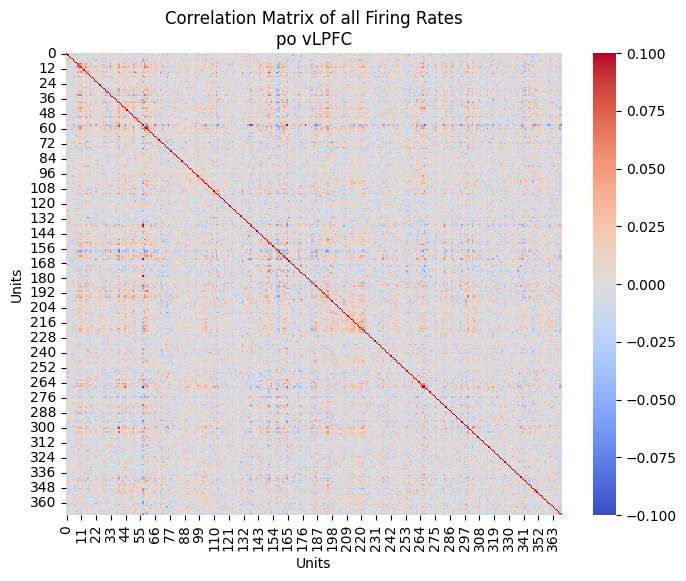

In [5]:
reshaped_data = neural_dataset.firing_rates.data.transpose(1, 0, 2).reshape(len(neural_dataset.unit), -1)

corr_matrix = np.corrcoef(reshaped_data)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-.1, vmax=.1)
plt.title(f'Correlation Matrix of all Firing Rates\n{monkey} {area_title}')
plt.xlabel('Units')
plt.ylabel('Units')
plt.show()

---
# PCA

## Fit & transform

In [6]:
pca_dataset, pca_components = fit_transform_data(neural_dataset)


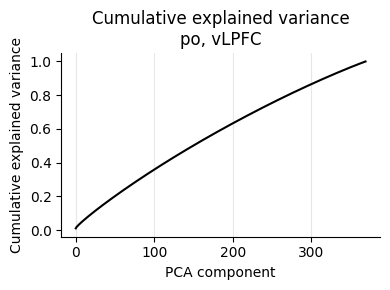

In [7]:
plot_explained_variance(pca_dataset, monkey, area_title)

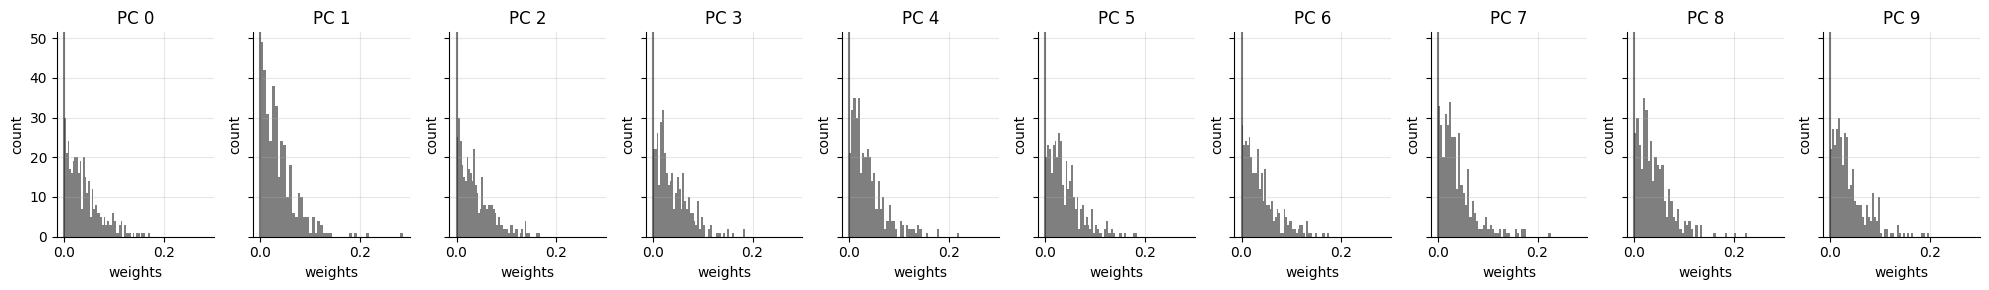

In [8]:
# plot the distribution of weights of the first component
fig, axs = plt.subplots(1, 10, figsize=(20, 3), sharex=True, sharey=True)
for i in range(10):
    axs[i].hist(np.abs(pca_components[i, :]), bins=50, color='k', alpha=.5)
    axs[i].axvline(0, color='k', alpha=.5)
    axs[i].set_title(f'PC {i}')
    axs[i].set_xlabel('weights')
    axs[i].set_ylabel('count')
    axs[i].grid(alpha=.3)
    sns.despine()
plt.tight_layout()

## Analyse PCs

In [9]:
i = 0

def get_weights_per_area(pca_components, pca_component):
    '''
    Get the weights of the PCA components per area
    '''
    weights_temp = pca_components.sel(pca_component=pca_component)

    # to df, where columns are monkey, session, area, unit, weight
    data_to_df = []
    for unit_temp in weights_temp.unit.values:
        data_to_df.append(
            {'monkey': unit_temp.split('_')[0],
            'session': unit_temp.split('_')[1],
            'area': unit_temp.split('_')[2],
            'unit': "_".join(unit_temp.split('_')[3:]),
            'weight': weights_temp.sel(unit=unit_temp).values
            }
        )
    df = pdr.DataFrame(data_to_df)
    df['weight_ratio'] =np.abs(df['weight'])/np.sum(np.abs(df['weight']))

    # get best weight per monkey, session, area (drop unit)
    df_abs = df.copy()
    df_abs['weight'] = df_abs['weight'].abs()

    df_best = df_abs.groupby(['monkey', 'session', 'area']).agg({'weight': 'max'}).reset_index()
    df_best = df_best.rename(columns={'weight': 'best_weight'})
    df_best['best_weight_ratio'] = df_best['best_weight'] / df_abs['weight'].sum()

    df_sum = df_abs.groupby(['monkey', 'session', 'area']).agg({'weight': 'sum'}).reset_index()
    df_sum = df_sum.rename(columns={'weight': 'sum_weight'})
    df_sum['sum_weight_ratio'] = df_sum['sum_weight'] / df_abs['weight'].sum()
    df_best = df_best.merge(df_sum, on=['monkey', 'session', 'area'], how='left')

    df_mean = df_abs.groupby(['monkey', 'session', 'area']).agg({'weight': 'mean'}).reset_index()
    df_mean = df_mean.rename(columns={'weight': 'mean_weight'})
    df_best = df_best.merge(df_mean, on=['monkey', 'session', 'area'], how='left')

    return df_best

get_weights_per_area(pca_components, 0)

,monkey,session,area,best_weight,best_weight_ratio,sum_weight,sum_weight_ratio,mean_weight
0,po,050922,LPFC,0.060672,0.004124,0.178353,0.012122,0.022294
1,po,070920,LPFC,0.140587,0.009555,0.925386,0.062893,0.084126
2,po,080422,LPFC,0.127764,0.008683,0.796717,0.054148,0.044262
3,po,080722,LPFC,0.172035,0.011692,1.78817,0.121532,0.071527
4,po,090721,LPFC,0.078767,0.005353,0.617351,0.041958,0.032492
5,po,090822,LPFC,0.060536,0.004114,0.634758,0.043141,0.02539
6,po,090920,LPFC,0.125461,0.008527,0.601612,0.040888,0.031664
7,po,100321,LPFC,0.007563,0.000514,0.014171,0.000963,0.003543
8,po,110920,LPFC,0.02591,0.001761,0.056716,0.003855,0.014179
9,po,140121,LPFC,0.103094,0.007007,0.703257,0.047797,0.03907


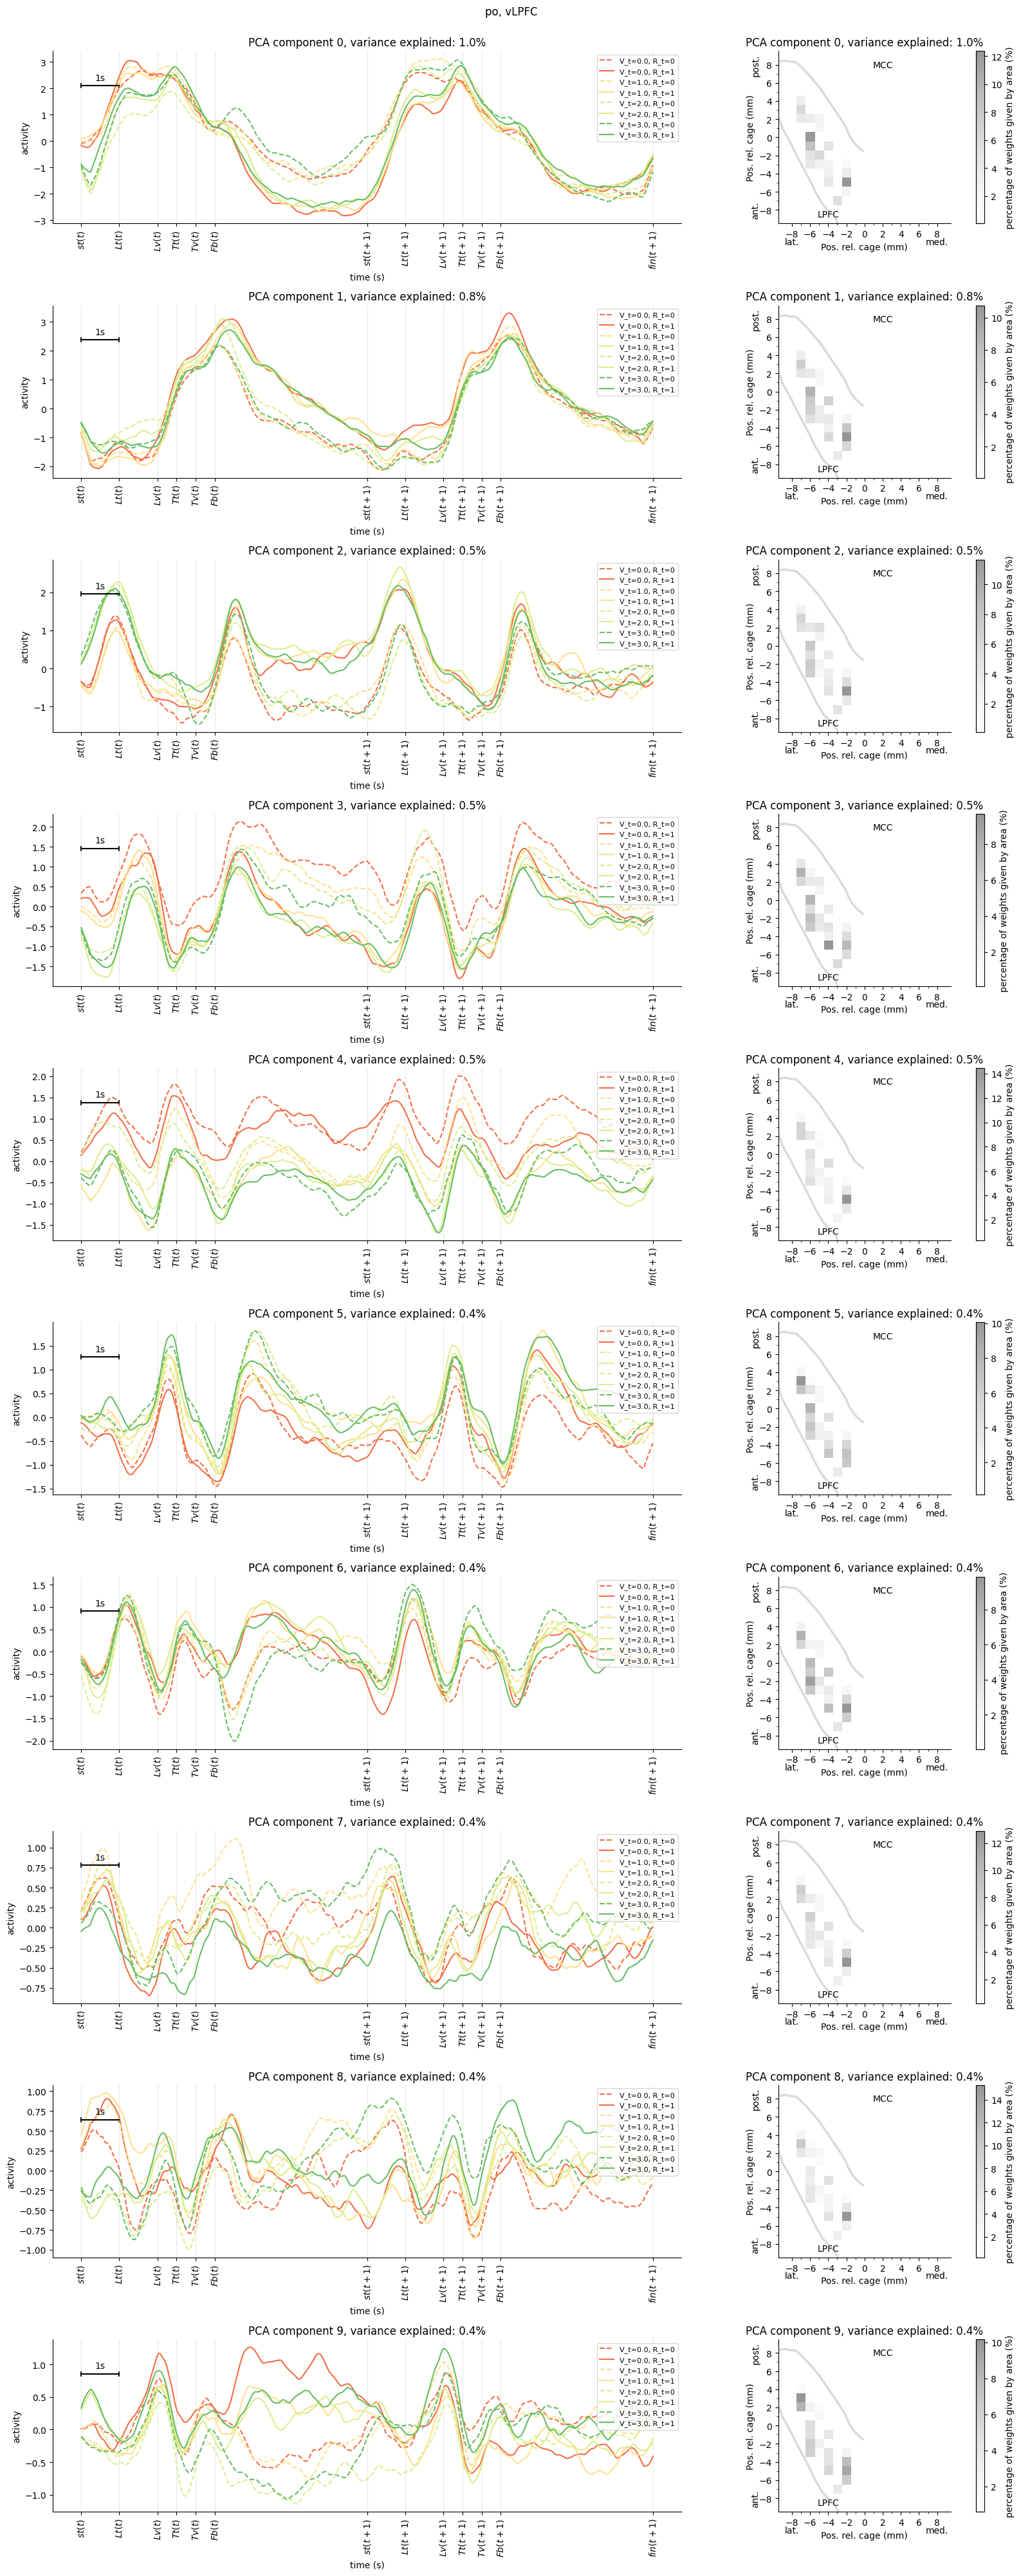

In [10]:
n_components = 10
t_min, t_max = None, None#0, 11
mean_subtract = False

# define what to show
value_labels = pca_dataset.fb_sequence_m1.values
outcome_labels = pca_dataset.R_1.values

# shoft time! it is necessary if the value now belongs to the previous trial
pca_dataset_time_shift = pca_dataset.copy(deep=True)
pca_dataset_time_shift = pca_dataset_time_shift.assign_coords(time=('time', pca_dataset_time_shift.time.values + 7.5))

fig, axs = plt.subplots(n_components, 2, figsize=(16, 4*n_components), sharex=False)
fig.suptitle(f'{monkey}, {area_title}', y=1)

colors = sns.color_palette("RdYlGn", len(np.unique(value_labels)))  # colors for each value
linestyles = {0:'--', 1:'-'}  # linestyles for each feedback

for i in range(n_components):
    # prepare data for this PC
    unit_data = pca_dataset_time_shift.firing_rates.sel(pca_component=i)  # select PC
    unit_data.data = np.array([np.convolve(trial, np.ones(50)/50, mode='same') for trial in unit_data.data])  # smooth the data

    if t_min is not None and t_max is not None:  # select time window
        unit_data = unit_data.sel(time=slice(t_min, t_max))  

    if mean_subtract:  # substract mean along time
        unit_data.data = unit_data.data - np.mean(unit_data.data, axis=0, keepdims=True)  

    # plot single PC activity
    ax = axs[i, 0]
    plot_single_unit(unit_data, value_labels, labels_2=outcome_labels,
                     title=f'PCA component {i}, variance explained: {pca_dataset_time_shift.explained_var[i]*100:.1f}%',
                     n_extra_trials=(0, 1),
                     ax=ax, colors=colors, linestyles=linestyles)
    ax.set_ylabel('activity')  # rewrite y label from firing rate to activity"""

    # plot weights on the surface
    """
    What should be the measure? The proble is the weights are correspondig to units, and we want to plot weights over areas, thus we need to average the weights over units somehow.
    Solution 1: average the weights over units per area
    Solution 2: Plot best unit per area
    Solution 3: plot proportion of weights per area relative to all units (e.g. 0.5 means that 50% of the weights are in this area)
    """
    ax = axs[i, 1]
    
    df_weights = get_weights_per_area(pca_components, i)
    df_weights['sum_weight_ratio'] = df_weights['sum_weight_ratio'] * 100  # convert to percentage

    plot_on_cortical_grid(df_weights, 'sum_weight_ratio', 
                          ax=ax, 
                          title=f'PCA component {i}, variance explained: {pca_dataset_time_shift.explained_var[i]*100:.1f}%',
                          bar_title='percentage of weights given by area (%)',) 

plt.tight_layout()

In [11]:
'''pc_a, pc_b = 4, 7
t_min, t_max = -3, 3
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True)
fig.suptitle(f'PCA components\n{monkey}, {area}', fontsize=16)
colors = sns.color_palette("RdYlGn", len(np.unique(pca_dataset.history_of_feedback)))

unit_data_a = pca_dataset.firing_rates.sel(pca_component=pc_a, time=slice(t_min, t_max))
unit_data_b = pca_dataset.firing_rates.sel(pca_component=pc_b, time=slice(t_min, t_max))
labels = pca_dataset.history_of_feedback.values

time_vector = unit_data.time.data

# get mean counts by condition
mean_counts_a = {label: np.mean(unit_data_a[unit_data_a.history_of_feedback == label], axis=0) for label in np.unique(labels)}
mean_counts_b = {label: np.mean(unit_data_b[unit_data_b.history_of_feedback == label], axis=0) for label in np.unique(labels)}

# plot trial-avg rates by condition
for i, label in enumerate(np.unique(labels)):
    ax.scatter(mean_counts_a[label], mean_counts_b[label], label=f'{label}', color=colors[i], s=10, alpha=.5)

ax.set_xlabel(f'{pc_a}')
ax.set_ylabel(f'{pc_b}')
# grid on x axis only
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
#ax.axhline(0, color='k', alpha=.5) # add zero line

# remove top and right spines
sns.despine()

ax.set_xlabel(f'PCA component {pc_a}, variance explained: {pca_dataset.explained_var[pc_a]*100:.1f}%')
ax.set_ylabel(f'PCA component {pc_b}, variance explained: {pca_dataset.explained_var[pc_b]*100:.1f}%')
#ax.legend(title='history of feedback', loc='upper right')
#ax.axhline(0, color='k', alpha=.5) # add zero line
# Add a box at the top left corner
x_loc = unit_data.time.data[0]
y_loc = ax.get_ylim()[1]
y_loc_text = y_loc - (ax.get_ylim()[1] - ax.get_ylim()[0]) * .18    '''

'pc_a, pc_b = 4, 7\nt_min, t_max = -3, 3\nfig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True)\nfig.suptitle(f\'PCA components\n{monkey}, {area}\', fontsize=16)\ncolors = sns.color_palette("RdYlGn", len(np.unique(pca_dataset.history_of_feedback)))\n\nunit_data_a = pca_dataset.firing_rates.sel(pca_component=pc_a, time=slice(t_min, t_max))\nunit_data_b = pca_dataset.firing_rates.sel(pca_component=pc_b, time=slice(t_min, t_max))\nlabels = pca_dataset.history_of_feedback.values\n\ntime_vector = unit_data.time.data\n\n# get mean counts by condition\nmean_counts_a = {label: np.mean(unit_data_a[unit_data_a.history_of_feedback == label], axis=0) for label in np.unique(labels)}\nmean_counts_b = {label: np.mean(unit_data_b[unit_data_b.history_of_feedback == label], axis=0) for label in np.unique(labels)}\n\n# plot trial-avg rates by condition\nfor i, label in enumerate(np.unique(labels)):\n    ax.scatter(mean_counts_a[label], mean_counts_b[label], label=f\'{label}\', color=colors[i], s=10, 

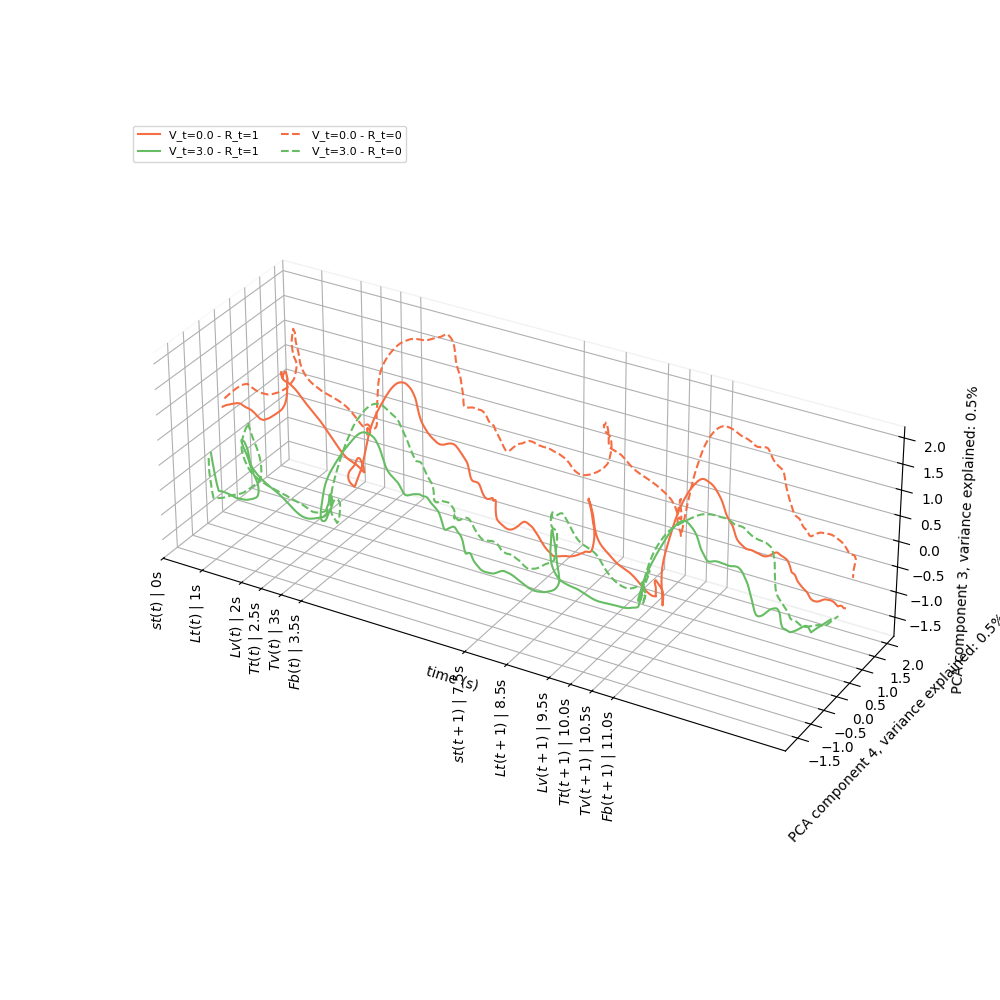

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib widget


pc_a, pc_b = 4, 3
t_min, t_max = 0, 14.9

# Create 3D figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#fig.suptitle(f'PCA components trajectories\n{monkey}, {area}', fontsize=16)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(axis='x')

# make the plot longer along the x axis
ax.set_box_aspect([3, 1, 1])  # aspect ratio is 1:1:1
#ax.set_xticks(np.arange(-3, 4, 1))
#ax.set_yticks(np.arange(-3, 4, 1))

# Get data
unit_data_a = pca_dataset.firing_rates.sel(pca_component=pc_a, time=slice(t_min- 7.5, t_max- 7.5))
#unit_data_a.data = unit_data_a.data - np.mean(unit_data_a.data, axis=0, keepdims=True)
unit_data_b = pca_dataset.firing_rates.sel(pca_component=pc_b, time=slice(t_min- 7.5, t_max- 7.5))
#unit_data_b.data = unit_data_b.data - np.mean(unit_data_b.data, axis=0, keepdims=True)
time_vector = pca_dataset.time.sel(time=slice(t_min- 7.5, t_max- 7.5)).values + 7.5

labels = pca_dataset.fb_sequence_m1.values
labels_2 = pca_dataset.R_1.values
colors = sns.color_palette("RdYlGn", len(np.unique(labels)))
linestyles = {0:'--', 1:'-'}

# Plot the trajectories for each condition
for i, label in enumerate(np.unique(labels)):
    if label in [1, 2]: continue
    # Get trials for this condition
    if labels_2 is not None:
        for j, label_2 in enumerate(np.unique(labels_2)):
                trial_ids = unit_data.trial_id[(labels == label) & (labels_2 == label_2)]
                mean_count_a = np.mean(unit_data_a.sel(trial_id=trial_ids), axis=0)
                mean_count_b = np.mean(unit_data_b.sel(trial_id=trial_ids), axis=0)

                # smooth in time
                mean_count_a_smooth_data = np.convolve(mean_count_a.values, np.ones(50)/50, mode='same')
                mean_count_b_smooth_data = np.convolve(mean_count_b.values, np.ones(50)/50, mode='same')

                # Plot the trajectory
                ax.plot(time_vector, mean_count_a_smooth_data, mean_count_b_smooth_data, label=f'V_t={label} - R_t={label_2}', color=colors[i], linestyle=linestyles[j])
    else:
        trial_ids = unit_data.trial_id[labels == label]
        mean_count_a = np.mean(unit_data_a.sel(trial_id=trial_ids), axis=0)
        mean_count_b = np.mean(unit_data_b.sel(trial_id=trial_ids), axis=0)

        # Plot the trajectory
        ax.plot(time_vector, mean_count_a.values, mean_count_b.values, label=f'V_t={label}', color=colors[i])
    
    # Add markers to show direction of time
    '''ax.scatter(time_vector, mean_a.values, mean_b.values, 
               color=colors[i], s=30, alpha=0.8)'''

# Set labels
ax.set_ylabel(f'PCA component {pc_a}, variance explained: {pca_dataset.explained_var[pc_a]*100:.1f}%')
ax.set_zlabel(f'PCA component {pc_b}, variance explained: {pca_dataset.explained_var[pc_b]*100:.1f}%')
ax.set_xlabel('Time (s)')

# Add legend
# reorder legend labels: put every second on the second column
handles, labels = ax.get_legend_handles_labels()
handles_pos = [handles[i] for i in range(len(labels)) if i % 2 == 1]
handles_neg = [handles[i] for i in range(len(labels)) if i % 2 == 0]
handles = handles_pos + handles_neg
labels_pos = [labels[i] for i in range(len(labels)) if i % 2 == 1]
labels_neg = [labels[i] for i in range(len(labels)) if i % 2 == 0]
labels = labels_pos + labels_neg
ax.legend(handles, labels, loc='upper left', fontsize=8, ncol=2)
#ax.legend(title='history of feedback', loc='upper right')

plot_keypoints(ax, n_extra_trials=(0, 1))

ax.set_xlim(t_min, t_max)

# Export 3d plot in interactive mode
# save to html

#plt.tight_layout()

plt.show()
